In [6]:
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake=50):
    Lx, Ly, Lz = box_lengths
    n_flakes = len(flake_positions) // beads_per_flake
    flake_coms = []

    for i in range(n_flakes):
        flake = flake_positions[i * beads_per_flake : (i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        com = np.mean(unwrapped, axis=0)

        # Wrap CoM into [-L/2, L/2]
        com[0] = (com[0] + Lx/2) % Lx - Lx/2
        com[1] = (com[1] + Ly/2) % Ly - Ly/2
        com[2] = (com[2] + Lz/2) % Lz - Lz/2

        flake_coms.append(com)

    return np.array(flake_coms)


In [8]:
def count_clusters(flake_coms, box_lengths, cutoff):
    Lx, Ly, Lz = box_lengths
    n = len(flake_coms)
    adjacency = [set() for _ in range(n)]

    # Build adjacency list using MIC
    for i in range(n):
        for j in range(i + 1, n):
            dr = flake_coms[j] - flake_coms[i]
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)
            dist = np.linalg.norm(dr)
            if dist < cutoff:
                adjacency[i].add(j)
                adjacency[j].add(i)

    visited = set()
    clusters = []

    # DFS to build clusters
    for i in range(n):
        if i not in visited and adjacency[i]:
            cluster = []
            stack = [i]
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    cluster.append(current)
                    stack.extend(adjacency[current] - visited)
            if len(cluster) > 1:  # Only count as cluster if size > 1
                clusters.append(cluster)

    return len(clusters), [len(c) for c in clusters]


In [9]:
def analyze_clusters_over_time(traj, start=0, step=1000, cutoff=2.5, beads_per_flake=50):
    times = []
    n_clusters_list = []
    avg_cluster_sizes = []

    for frame_idx in range(start, len(traj), step):
        frame = traj[frame_idx]
        box_lengths = frame.configuration.box[:3]

        flake_type = "F"
        flake_typeid = frame.particles.types.index(flake_type)
        positions = frame.particles.position
        typeids = frame.particles.typeid
        flake_positions = positions[typeids == flake_typeid]

        flake_coms = compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake)
        n_clusters, sizes = count_clusters(flake_coms, box_lengths, cutoff)

        times.append(frame_idx)
        n_clusters_list.append(n_clusters)
        avg_cluster_sizes.append(np.mean(sizes) if sizes else 0)

    return times, n_clusters_list, avg_cluster_sizes

In [10]:
traj = gsd.hoomd.open("100_10mer10f_0.0005dt_7kT_large.gsd")
times, n_clusters, avg_sizes = analyze_clusters_over_time(
    traj,
    start=5000,   # post-shrink
    step=1,
    cutoff=2.5,
    beads_per_flake=50
)

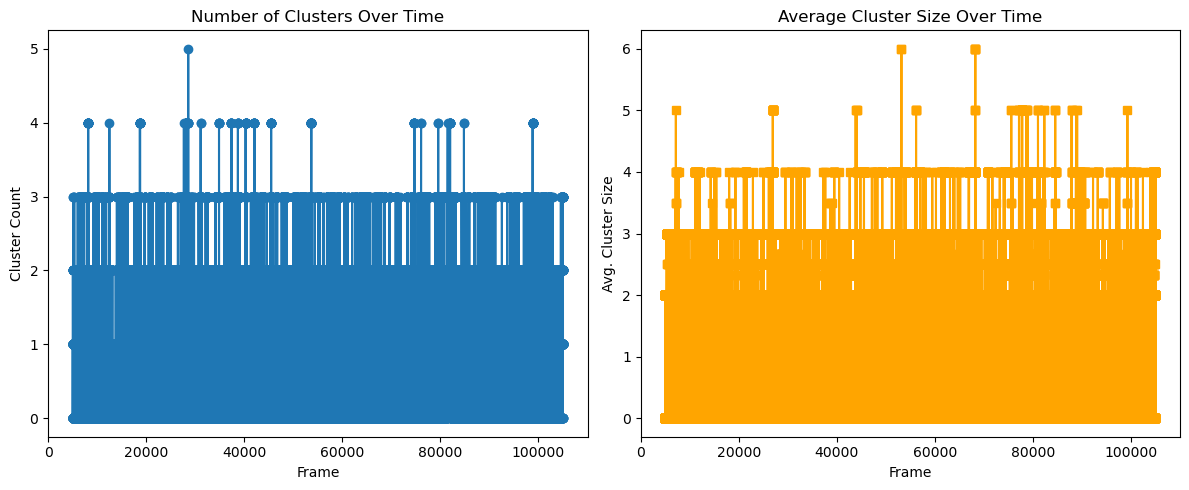

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(times, n_clusters, marker='o')
plt.title("Number of Clusters Over Time")
plt.xlabel("Frame")
plt.ylabel("Cluster Count")

plt.subplot(1, 2, 2)
plt.plot(times, avg_sizes, marker='s', color='orange')
plt.title("Average Cluster Size Over Time")
plt.xlabel("Frame")
plt.ylabel("Avg. Cluster Size")

plt.tight_layout()
plt.show()

In [13]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))  
    acorr = np.fft.irfft(ft * np.conjugate(ft))  
    acorr /= (len(array) * np.var(array))        

    dt = np.where(acorr < 0)[0][0]               
    nsamples = len(array) // dt                  

    acorr = acorr[dt:nsamples]                  

    return nsamples, dt
n, dt = autocorr1D(avg_sizes)

In [15]:
print("Decorrelated sample and decorrelation time:", n, dt)

Decorrelated sample and decorrelation time: 305 327


In [6]:
print(avg_sizes[4411])

IndexError: list index out of range

In [7]:
len(times)

5001

In [8]:
def compute_all_flake_coms_from_38th(flake_positions, box_lengths, beads_per_flake=50):
    Lx, Ly, Lz = box_lengths
    n_flakes = len(flake_positions) // beads_per_flake
    flake_coms = []

    for i in range(n_flakes):
        idx = i * beads_per_flake + 37
        pos = np.array(flake_positions[idx])

        # Wrap position into [-L/2, L/2]
        pos[0] = (pos[0] + Lx / 2) % Lx - Lx / 2
        pos[1] = (pos[1] + Ly / 2) % Ly - Ly / 2
        pos[2] = (pos[2] + Lz / 2) % Lz - Lz / 2

        flake_coms.append(pos)

    return np.array(flake_coms)

In [9]:
def find_flake_neighbors(coms, box_lengths, cutoff):
    Lx, Ly, Lz = box_lengths
    n = len(coms)
    for i in range(n):
        neighbors = []
        for j in range(n):
            if i == j:
                continue
            dr = coms[j] - coms[i]
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)
            dist = np.linalg.norm(dr)
            if dist < cutoff:
                neighbors.append((j, dist))
        if neighbors:
            neighbor_str = ", ".join([f"Flake {j} (distance: {d:.2f})" for j, d in neighbors])
            print(f"Flake {i} is neighbors with: {neighbor_str}")
        else:
            print(f"Flake {i} has no neighbors within cutoff range.")

In [23]:
traj = gsd.hoomd.open("100_10mer10f_0.0005dt_7kT_large.gsd")
frame = traj[93180]  # frame index

In [24]:
flake_type = "F"
flake_typeid = frame.particles.types.index(flake_type)
positions = frame.particles.position
typeids = frame.particles.typeid
flake_positions = positions[typeids == flake_typeid]

Lx, Ly, Lz = frame.configuration.box[:3]

flake_coms = compute_all_flake_coms(flake_positions, (Lx, Ly, Lz), beads_per_flake=50)
find_flake_neighbors(flake_coms, (Lx, Ly, Lz), cutoff=2.5)

Flake 0 is neighbors with: Flake 6 (distance: 1.04)
Flake 1 has no neighbors within cutoff range.
Flake 2 has no neighbors within cutoff range.
Flake 3 is neighbors with: Flake 9 (distance: 2.35)
Flake 4 has no neighbors within cutoff range.
Flake 5 has no neighbors within cutoff range.
Flake 6 is neighbors with: Flake 8 (distance: 1.26)
Flake 7 has no neighbors within cutoff range.
Flake 8 is neighbors with: Flake 6 (distance: 1.26)
Flake 9 is neighbors with: Flake 3 (distance: 2.35)


In [67]:
print(Lx,Ly,Lz)

17.09976 17.09976 17.09976


In [68]:
print(flake_coms)

[[-1.8657905   7.174376    0.13797691]
 [-6.596167    7.675875   -7.200569  ]
 [ 8.170121   -1.5282594   3.7152588 ]
 [ 4.464428    2.351693    5.5135465 ]
 [-1.7335142  -5.094418    1.9472373 ]
 [-2.6565433  -4.2195535  -3.1058908 ]
 [ 4.866673   -2.4554129   2.6737108 ]
 [-4.514638    2.8086731  -7.7552233 ]
 [ 4.31046    -1.4952607   2.7449508 ]
 [ 3.8405015  -0.24392131  2.6731768 ]]


In [10]:
flake_coms[7]

array([-4.514638 ,  2.8086731, -7.7552233], dtype=float32)

In [11]:
len(flake_coms)

10

In [12]:
flake_coms[9]

array([ 3.8405015 , -0.24392131,  2.6731768 ], dtype=float32)

In [13]:
flake_coms[7]

array([-4.514638 ,  2.8086731, -7.7552233], dtype=float32)

In [14]:
def mic_distance(pos1, pos2, box_lengths):
    Lx, Ly, Lz = box_lengths
    dr = pos1 - pos2
    dr[0] -= Lx * np.round(dr[0] / Lx)
    dr[1] -= Ly * np.round(dr[1] / Ly)
    dr[2] -= Lz * np.round(dr[2] / Lz)
    return np.linalg.norm(dr)

In [15]:
box_lengths = (17.09976, 17.09976, 17.09976)
distance = mic_distance(flake_coms[8], flake_coms[9], box_lengths)
print(distance)

1.3386048


In [16]:
distance = np.linalg.norm(flake_coms[8] - flake_coms[9])
print(distance)

1.3386048


In [17]:
print(flake_coms[8])

[ 4.31046   -1.4952607  2.7449508]


In [18]:
print(flake_coms[9])

[ 3.8405015  -0.24392131  2.6731768 ]
